# Optical Fiber Specklegram Sensors (FSS)

##### Optical Fiber Specklegram Sensors (FSS) offer an appealing solution for environmental sensing due to their straightforward sensing arrangement and processable digital output, which encodes rich information. These sensors utilize the interference pattern changes observed in the cross-sectional area of a multimode optical fiber (MMF) to measure various chemical and physical quantities in the surrounding environment. In our lab, we present an FSS structure capable of accurately measuring environmental parameters. To train and test our model, we recorded an image dataset of fiber output speckles with a microfiber immersed in seven distinct solutions. These solutions were carefully selected to possess varying refractive indices while being closely related to one another. By leveraging this dataset, we trained a deep neural network to analyze the speckle patterns and extract meaningful information. The obtained results demonstrate a remarkable accuracy of 99.26% in the classification of the seven solutions based on their refractive indices.

## importing necessary libraries

In [20]:
import os
import torch
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50

## Define the path to your dataset

In [22]:
data_dir = "D:/Deep Learning/Datasets/cropped 4,7,2023/"# Define transforms
transform = transforms.Compose([transforms.RandomRotation(degrees=(-10,10)),
    transforms.ColorJitter(brightness=(0.9,1.1), contrast=(0.9,1.1), saturation=(0.9,1.1), hue=(-0.02,0.02)),                                
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    ])

## Create a dataset using the ImageFolder class

In [5]:
dataset = ImageFolder(data_dir , transform=transform)

## Define the size of each subset

In [6]:
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

## Split dataset

In [7]:
num_train = int(len(dataset) * 0.7)
num_val = int(len(dataset) * 0.1)
num_test = len(dataset) - num_train - num_val
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [num_train, num_val, num_test])

## creating dataloader for each subsets

In [8]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

## Create an instance of the ResNet50 model

In [10]:
model = resnet50(pretrained=False)

C:\Users\Mojtaba\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

C:\Users\Mojtaba\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.

  warnings.warn(msg)


## Replace last fully-connected layer with new layer to match number of classes

In [11]:
num_classes = 7
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

## computing and train by GPU and move the model to the device

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [13]:
model = model.to(device)

## Define the loss function and optimizer

In [14]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

## Train the model on the train set

In [16]:
num_epochs = 4
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate on validation set
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}, Validation Accuracy: {accuracy:.2f}%')

Epoch 1/1, Loss: 0.5114, Validation Accuracy: 95.24%


## Evaluate on test set

In [17]:
with torch.no_grad():
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())
    accuracy = 100 * correct / total

print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 95.24%


## plotting the confusion matrix

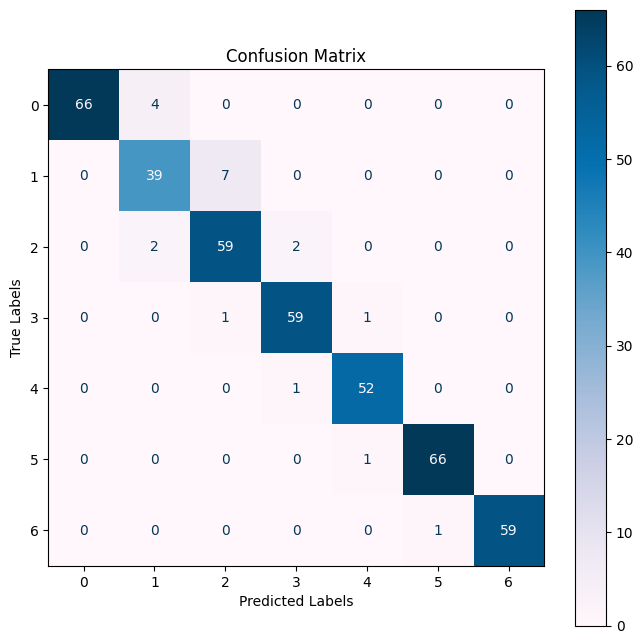

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class_names = dataset.classes
cm = confusion_matrix(all_targets, all_preds)

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp = disp.plot(ax=ax, cmap=plt.cm.PuBu, values_format='.0f')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## save model

In [19]:
torch.save(model.state_dict(), 'my_model_4_7_2023.pt')

## Get a random sample of test images for visualize

In [ ]:
data_iter = iter(test_loader)
images, labels = data_iter.__next__()

images = images.to(device) 
labels = labels.to(device)

## Make predictions for the test images

In [ ]:
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

In [ ]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Move the images and labels back to the CPU and convert them to NumPy arrays

In [ ]:
images = images.cpu().numpy()
labels = labels.cpu().numpy()

## Visualize the test images and their predicted classes

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axs.flatten()):
    image = images[i].transpose(1, 2, 0)
    #image = (image * np.array((0.229, 0.224, 0.225))) + np.array((0.485, 0.456, 0.406))
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.set_title(f'Predicted: {classes[predicted[i]]}\nActual: {classes[labels[i]]}')
    ax.axis('off')
plt.subplots_adjust(
                    wspace=0.1,
                    hspace=0.4)
plt.show()